In [10]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [11]:
class SlotMachine:
    """SlotMachine class."""
    
    def __init__(self, win_rate:float = 0.01) -> None:
        """ Slot machine constructor.
        
            Args:
                win_rate (float): true machine win rate.
        """
        self.win_rate = win_rate
        
    def play(self) -> float:
        """Play machine.
        
            Return:
                win (float): 1 with probability self.win_rate, 0 otherwise.
        
        """
        
        # win
        win = 1. if np.random.rand() < self.win_rate else 0
        
        return win
    
    def test(self) -> None:
        """Test convergence to self.win_rate"""
        
        # play machine several times and compute mean
        returns = [self.play() for _ in range(100000)]
        
        # test
        np.testing.assert_almost_equal(actual=np.mean(returns), desired=self.win_rate, decimal=2)

In [12]:
# test machine implementation
for _ in range(30):
    SlotMachine(win_rate=np.random.rand()).test()

In [13]:
class Bandit:
    """Bandit class."""
     
    def __init__(self, machines:list, epsilon:float = 1e-1, decay_rate:float = 0.99):
        """Bandit constructor.
        
            Args:
                machines (list): list of SlotMachine.
                epsilon (float): exploration level for epsilon-greedy algorithm.
                decay (float): decay for epsilon-greedy algorithm.
                
        """
        # machines
        self.machines = machines
        self.n = len(machines)
        
        # policy
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        
        # attributes
        self.round = 0
        self.machine_win_rates = np.zeros((1, self.n))
        self.cumulative_machine_played = np.zeros((1, self.n))
        self.n_times_machine_played = {i:0 for i in range(self.n)}
        self.n_times_machine_win = {i:0 for i in range(self.n)}
        
    def choose_machine(self) -> int:
        """Choose which machine to play.
        
            Return:
                i (int): index of chosen machine.
        
        """
        
        # epsilon at round t+1 is self.decay_rate of epsilon at round t
        # e^(a(t+1)) / e^(at) = self.decay_rate -> a = log(self.decay_rate)
        epsilon_t = np.exp(np.log(self.decay_rate)*self.round) * self.epsilon
                
        # exploration
        if np.random.rand() < epsilon_t or self.round == 0:
            i = np.random.choice(self.n)
        
        # exploitation
        else:
            i = np.argmax(self.machine_win_rates[self.round, :])
        
        return i
    
    def play(self) -> None:
        """Play machine i."""
        
        # choose machine
        i = self.choose_machine()
        machine = self.machines[i]
        
        # play chosen machine
        machine_output = machine.play()
        
        # update state
        self.round += 1
        self.n_times_machine_played[i] += 1
        self.n_times_machine_win[i] += machine_output
        self.machine_win_rates = np.r_[self.machine_win_rates, self.machine_win_rates[[-1], :]]
        self.machine_win_rates[self.round, i] = self.n_times_machine_win[i]/self.n_times_machine_played[i]
        self.cumulative_machine_played = np.r_[self.cumulative_machine_played, 
                                               self.cumulative_machine_played[[-1], :]]
        self.cumulative_machine_played[self.round, i] += 1
    
    def reset(self) -> None:
        """Reset state."""
        
        # attributes
        self.round = 0
        self.machine_win_rates = np.zeros((1, self.n))
        self.n_times_machine_played = {i:0 for i in range(self.n)}
        self.n_times_machine_win = {i:0 for i in range(self.n)}

In [14]:
# run simulation
machines = [SlotMachine(win_rate=0.1), SlotMachine(win_rate=0.2), SlotMachine(win_rate=0.3)]
bandit = Bandit(machines=machines, epsilon=.3, decay_rate=.999)

In [15]:
# loop over
n_rounds = 8000
for _ in range(n_rounds):
    bandit.play()

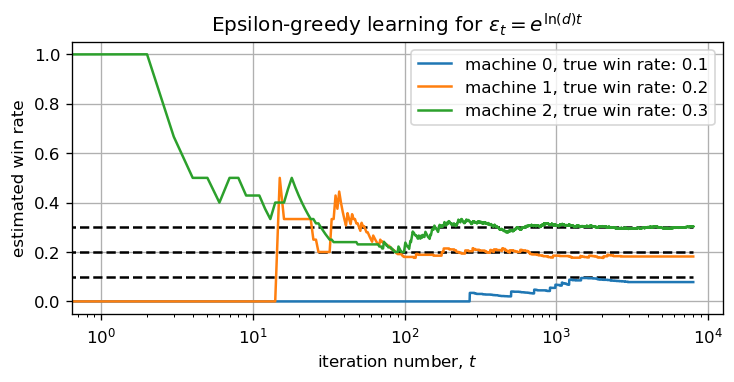

In [16]:
# plot results
plt.figure(figsize=(7, 3), dpi=120)
plt.plot(bandit.machine_win_rates)
plt.legend(['machine ' + str(i) + f', true win rate: {machines[i].win_rate}' for i in range(len(machines))],
          loc='upper right')
plt.hlines([m.win_rate for m in machines], xmin=0, xmax=n_rounds, linestyle='--')
plt.xscale('log')
plt.xlabel('iteration number, $t$')
plt.ylabel('estimated win rate')
plt.title('Epsilon-greedy learning for $\epsilon_t = e^{\ln(d)t}$')
plt.grid()
plt.show()

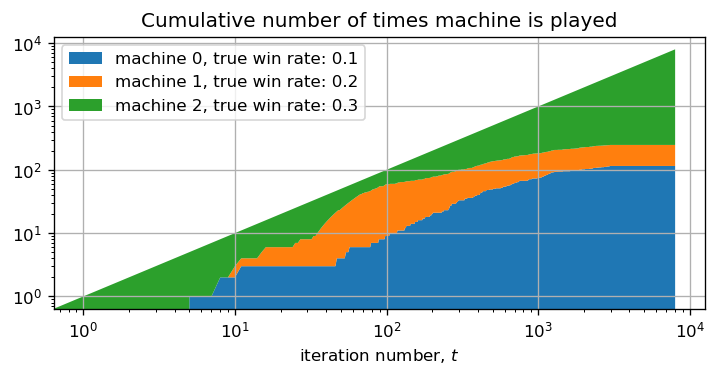

In [17]:
# cumulative
plt.figure(figsize=(7, 3), dpi=120)
plt.stackplot(range(bandit.round+1),
              bandit.cumulative_machine_played.T)
plt.legend(['machine ' + str(i) + f', true win rate: {machines[i].win_rate}' for i in range(len(machines))], 
          loc='upper left')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('iteration number, $t$')
plt.title('Cumulative number of times machine is played')
plt.grid()
plt.show()